<font size="5">
  

# AirBnB pricing predication - Compairing Randon Forsts and XGBoost 
## COMP 4447 Data Scince Tools 1
Rodney Cordova

----



## Import the modules that

In [74]:
import pandas as pd 
import numpy as np 
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import mapclassify as mc
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Import the data

The dataset used in this analysis from the **[Inside Airbnb](http://insideairbnb.com/get-the-data.html)** site. Inside Airbnb aggregates data on listings and reviews from the AirBnB website. For this analysis we are using listings from Denver, Colorado.

In [2]:
url = 'http://data.insideairbnb.com/united-states/co/denver/2020-06-28/data/listings.csv.gz'
r = requests.get(url, allow_redirects=True)

open('listings.csv.gz', 'wb').write(r.content)

4872217

In [3]:
df = pd.read_csv('listings.csv.gz', compression='gzip')

In [4]:
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,177,https://www.airbnb.com/rooms/177,20200628212359,2020-06-29,Tiny Home in the Heart of the City- ECO FRIENDLY,"160 sq ft + 80 sq ft loft for sleeping, Sleeps...",Here's the fun details of this Tiny Home exper...,"160 sq ft + 80 sq ft loft for sleeping, Sleeps...",none,"Quiet neighborhood next to park, creeks and bi...",...,f,f,strict_14_with_grace_period,f,f,3,3,0,0,1.25
1,360,https://www.airbnb.com/rooms/360,20200628212359,2020-06-29,Sit in the Peaceful Garden of the Chickadee Co...,Enjoy the famous Colorado weather and unplug i...,Chickadee Cottage is the largest of our guest ...,Enjoy the famous Colorado weather and unplug i...,none,The cottage is located in the center of Lower ...,...,f,f,strict_14_with_grace_period,t,t,2,2,0,0,5.15
2,364,https://www.airbnb.com/rooms/364,20200628212359,2020-06-29,Lodo / RiNo LOFT via airport train,"Modern 1,000 square foot loft in the heart of ...","BRAND NEW FOR 2016 - April 22, 2016 - the air...","Modern 1,000 square foot loft in the heart of ...",none,"Ten brewpubs within walking distance, two grea...",...,f,f,strict_14_with_grace_period,f,f,1,1,0,0,0.64
3,590,https://www.airbnb.com/rooms/590,20200628212359,2020-06-29,Comfortable - and a great value!,"Large guest room in my home, where I also live...",I have been enjoying welcoming many wonderful ...,"Large guest room in my home, where I also live...",none,I love the diversity of my neighborhood and it...,...,f,f,flexible,f,f,2,0,2,0,4.38
4,592,https://www.airbnb.com/rooms/592,20200628212359,2020-06-29,private,This room is in the basement. It does not hav...,This is a basement room. You can sometimes he...,This room is in the basement. It does not hav...,none,NaN,...,f,f,flexible,f,f,2,0,2,0,1.30


In [5]:
df.dtypes

id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
name                                             object
                                                 ...   
calculated_host_listings_count                    int64
calculated_host_listings_count_entire_homes       int64
calculated_host_listings_count_private_rooms      int64
calculated_host_listings_count_shared_rooms       int64
reviews_per_month                               float64
Length: 106, dtype: object

## 1. Data Cleaning 

In [6]:
#columns
for i in df.columns:
    print(i)

id
listing_url
scrape_id
last_scraped
name
summary
space
description
experiences_offered
neighborhood_overview
notes
transit
access
interaction
house_rules
thumbnail_url
medium_url
picture_url
xl_picture_url
host_id
host_url
host_name
host_since
host_location
host_about
host_response_time
host_response_rate
host_acceptance_rate
host_is_superhost
host_thumbnail_url
host_picture_url
host_neighbourhood
host_listings_count
host_total_listings_count
host_verifications
host_has_profile_pic
host_identity_verified
street
neighbourhood
neighbourhood_cleansed
neighbourhood_group_cleansed
city
state
zipcode
market
smart_location
country_code
country
latitude
longitude
is_location_exact
property_type
room_type
accommodates
bathrooms
bedrooms
beds
bed_type
amenities
square_feet
price
weekly_price
monthly_price
security_deposit
cleaning_fee
guests_included
extra_people
minimum_nights
maximum_nights
minimum_minimum_nights
maximum_minimum_nights
minimum_maximum_nights
maximum_maximum_nights
minimum_ni

### Feature Reduction

In [7]:
#remove urls 
df.drop(columns = ['listing_url','thumbnail_url','medium_url','picture_url',
                  'xl_picture_url','host_url','host_thumbnail_url','host_picture_url'], inplace = True)

In [8]:
#remove text features
df.drop(columns = ['name','summary','space','description','neighborhood_overview',
                  'notes','transit','access','interaction','house_rules','host_about',
                  'host_verifications','amenities','jurisdiction_names','host_name','host_location','calendar_updated'
                  ,'license'], inplace = True)

In [9]:
#duplicate features.
# street = City, state, country - street removed
# mart_location = City, state - market_location removed
# country_code = country - country_code removed 
# host_listings_count = host_total_listings_count - host_listings_count removed
# market = Denver

df.drop(columns = ['street','smart_location','country_code','host_listings_count','market'],inplace = True)

In [10]:
#remove signle unique Value
df['state'] = df['state'].str.lower()
for i in df.columns:
    if df[i].nunique() == 1 or df[i].nunique() == 0:
        print(i + " : " + str(df[i].nunique()) + " : Unique Value =" +str(df[i].unique()))

scrape_id : 1 : Unique Value =[20200628212359]
experiences_offered : 1 : Unique Value =['none']
neighbourhood_group_cleansed : 0 : Unique Value =[nan]
state : 1 : Unique Value =['co']
country : 1 : Unique Value =['United States']
has_availability : 1 : Unique Value =['t']
is_business_travel_ready : 1 : Unique Value =['f']


In [11]:
df.drop(columns = ['scrape_id','experiences_offered','has_availability',
                   'is_business_travel_ready','neighbourhood_group_cleansed','country','state'],inplace = True)

In [12]:
#removed noncleased
df.drop(columns =['neighbourhood'],inplace = True)

### Feature Engineering 

In [13]:
#convert host_response_rate and host_acceptance_rate to floats 
df['host_response_rate'] = df['host_response_rate'].str.replace('%', '').astype('float').div(100)
df['host_acceptance_rate'] = df['host_acceptance_rate'].str.replace('%', '').astype('float').div(100)

In [14]:
#convert dollar columns to floats
dollar = ['price','weekly_price','monthly_price','security_deposit','cleaning_fee','extra_people']
for col in dollar:
    df[col] = df[col].str.replace('$', '').str.replace(',', '').astype('float')

In [15]:
#covert date to year and get the the differince in new column:
df['host_since'] = df['host_since'].astype('str')
df['host_since'] = pd.to_datetime(df['host_since'])
df['last_scraped'] = df['last_scraped'].astype('str')
df['last_scraped'] = pd.to_datetime(df['last_scraped'])

df['host_for_years'] = (((df['last_scraped'] - df['host_since'])/ np.timedelta64(1, 'D')))/365

In [16]:
#convert first_reveiw and last reveiw in years. 
df['first_review'] = df['first_review'].astype('str')
df['first_review'] = ((df['last_scraped'] - pd.to_datetime(df['first_review'])) / np.timedelta64(1, 'D'))/365
df['last_review'] = df['last_review'].astype('str')
df['last_review'] = ((df['last_scraped'] - pd.to_datetime(df['last_review'])) / np.timedelta64(1, 'D'))/365

In [17]:
#remove scrape and date features
df.drop(columns = ['id','last_scraped','calendar_last_scraped','host_since'], inplace = True)

In [18]:
#change all catigoricals to lower for use in one hot encomding later
lower_cat = ['host_response_time','host_is_superhost','host_neighbourhood','host_has_profile_pic',
            'host_identity_verified','neighbourhood_cleansed','city','zipcode','property_type','room_type',
            'bed_type','requires_license','instant_bookable','cancellation_policy','require_guest_profile_picture',
            'require_guest_phone_verification']

for i in lower_cat:
    df[i] = df[i].str.lower()


In [19]:
#remove the 'co' from some zipcodes
df['zipcode'] = df['zipcode'].astype('str') 
df['zipcode'] = df['zipcode'].str.lstrip('co ')
df['zipcode'] = df['zipcode'].str.strip()
df['zipcode'] = df['zipcode'].replace('nan', np.nan)
df['zipcode'].unique()


array(['80246', '80211', '80205', '80207', '80223', '80220', '80203',
       '80110', '80209', '80202', '80218', '80206', '80230', '80212',
       '80210', '80222', '80219', '80238', '80204', nan, '80247', '80249',
       '80231', '80235', '80113', '80227', '80237', '80236', '80224',
       '80221', '80214', '80216', '80123', '80014', '80033', '80239',
       '80011', '80010', '80019', '80127', '81427', '80226'], dtype=object)

In [20]:
# df['zipcode']=df['zipcode'].replace('nan', None)
# df['zipcode'].unique()
# df['zipcode'].shape


In [21]:
#check feature types
for i in df.columns:
    print(i + " : " + str(df[i].dtype))

host_id : int64
host_response_time : object
host_response_rate : float64
host_acceptance_rate : float64
host_is_superhost : object
host_neighbourhood : object
host_total_listings_count : int64
host_has_profile_pic : object
host_identity_verified : object
neighbourhood_cleansed : object
city : object
zipcode : object
latitude : float64
longitude : float64
is_location_exact : object
property_type : object
room_type : object
accommodates : int64
bathrooms : float64
bedrooms : float64
beds : float64
bed_type : object
square_feet : float64
price : float64
weekly_price : float64
monthly_price : float64
security_deposit : float64
cleaning_fee : float64
guests_included : int64
extra_people : float64
minimum_nights : int64
maximum_nights : int64
minimum_minimum_nights : int64
maximum_minimum_nights : int64
minimum_maximum_nights : int64
maximum_maximum_nights : int64
minimum_nights_avg_ntm : float64
maximum_nights_avg_ntm : float64
availability_30 : int64
availability_60 : int64
availability_90

### Missing Values

In [22]:
#missing 
df.isnull().sum().sum()

22371

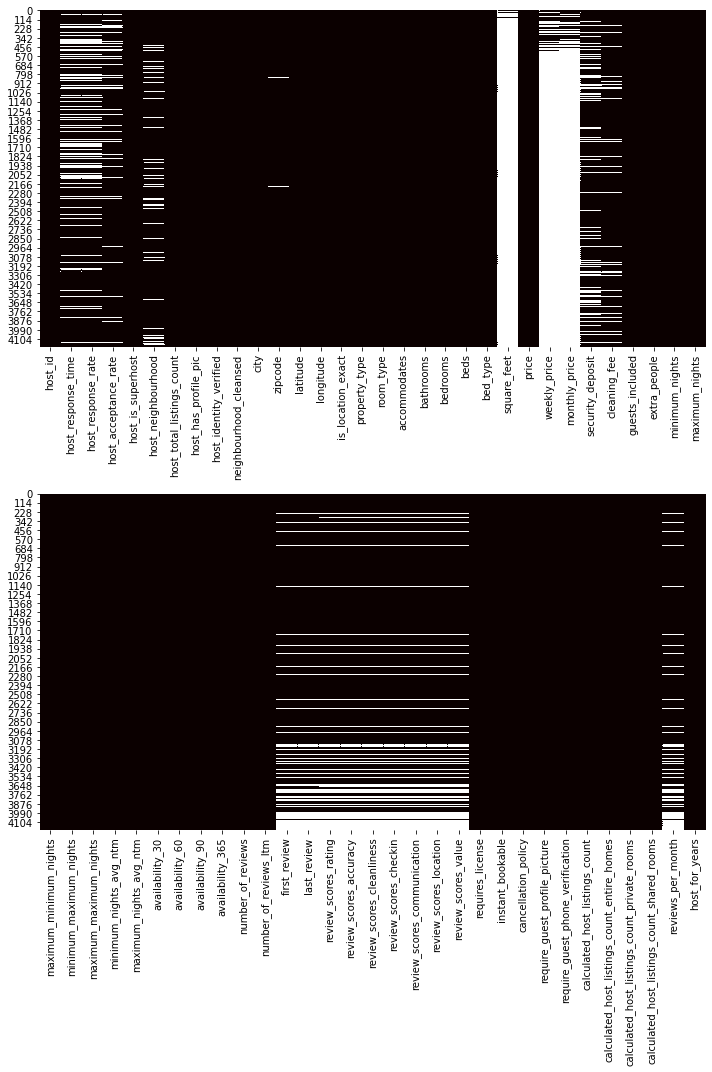

In [23]:
%matplotlib inline 
# sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
fig, axes = plt.subplots(2, 1, figsize = (10,15))
sns.heatmap(df.iloc[:, 0:32].isnull(), cbar=False, cmap='hot',ax = axes[0])
sns.heatmap(df.iloc[:, 33:].isnull(), cbar=False, cmap='hot',ax = axes[1])
plt.tight_layout()
plt.show()

In [24]:
#search for high rates of missing values 
for i in df.columns:
    missing_rate = df[i].isnull().sum() / df[i].shape[0]
    if missing_rate >0.6:
        print(i + " - " + str(missing_rate))

square_feet - 0.9959523809523809
weekly_price - 0.9319047619047619
monthly_price - 0.9414285714285714


In [25]:
#drop hgih missing rate
df.drop(columns = ['square_feet','weekly_price','monthly_price'],inplace=True)

In [26]:
# Impute missing data. For float / int column impute = mean. For catigorical column impute = mode   
for i in df.columns:
    if df[i].dtype == float or df[i].dtype == int:
        df[i].fillna(df[i].mean(), inplace=True)
    else:
        df[i].fillna(df[i].mode()[0], inplace=True)

In [27]:
df.isnull().sum().sum()

0

## 2. EDA

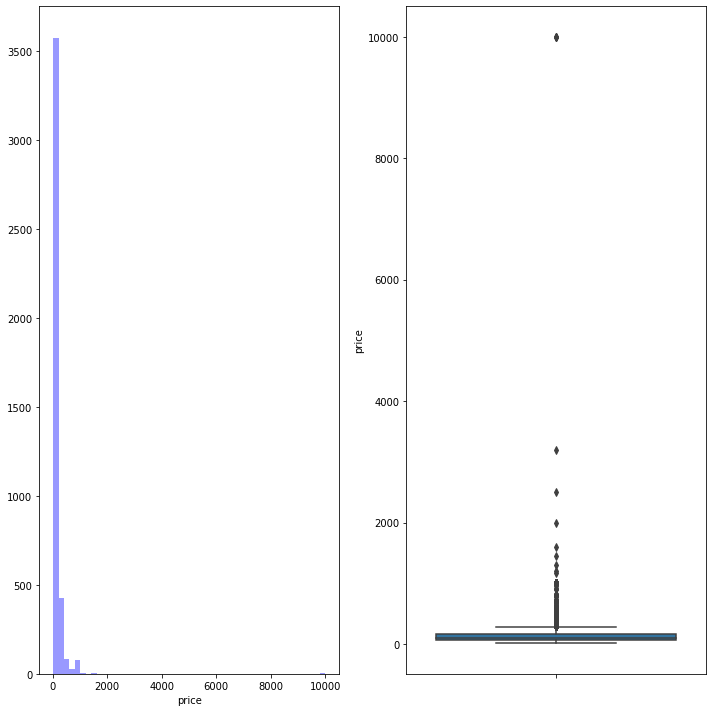

In [28]:
#access price distrbution 
fig, axes = plt.subplots(1,2, figsize = (10,10))
sns.distplot(df['price'], kde=False,color="b",ax=axes[0])
sns.boxplot(y='price',data=df)
plt.tight_layout()

In [29]:
#check threshould for price outliers
df['price'].mean() + 3 * df['price'].std()

1208.1092640061463

In [30]:
#identify outliers
outliers = df[df['price'] > df['price'].mean() + 3 * df['price'].std()]
outliers['price']

682      9999.0
1309    10000.0
1792     1299.0
1964     1450.0
2541     9999.0
2956    10000.0
3204     2500.0
3334     3200.0
3719     2000.0
3819     1599.0
Name: price, dtype: float64

In [31]:
#drop outliers
df = df[df['price'] < df['price'].mean() + 3 * df['price'].std()]

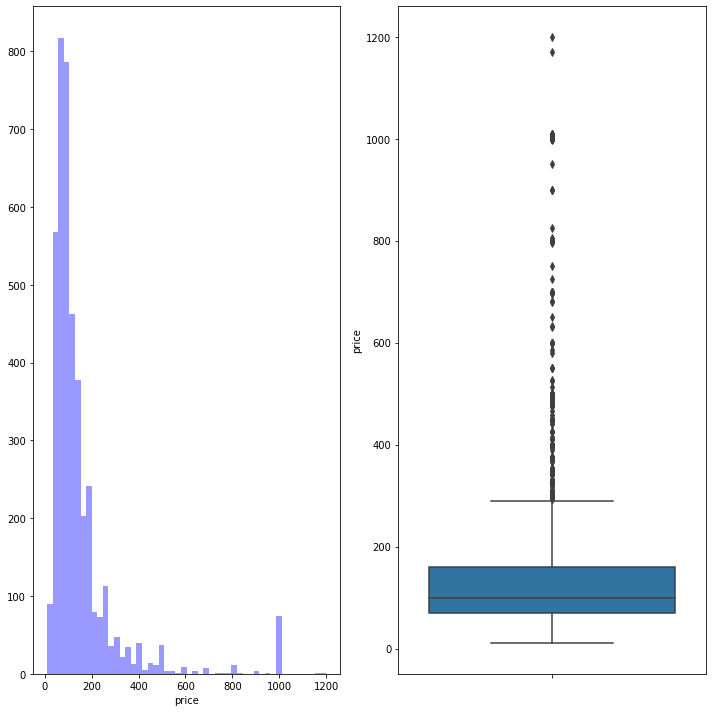

In [32]:
#reaccess price distobution
fig, axes = plt.subplots(1,2, figsize = (10,10))
sns.distplot(df['price'],kde=False, color="b",ax=axes[0])
sns.boxplot(y='price',data=df)
plt.tight_layout()

In [33]:
#outliers by neighbourhood
df[df['price'] > df['price'].mean() + 3 * df['price'].std()].groupby('neighbourhood_cleansed')['price'].count()

neighbourhood_cleansed
belcaro                          1
berkeley                         2
capitol hill                     3
cbd                              4
city park west                   1
civic center                     1
cole                             1
dia                              1
five points                     63
gateway - green valley ranch     1
hale                             1
highland                         9
jefferson park                   1
sloan lake                       2
speer                            1
sunnyside                        2
union station                    3
university hills                 1
university park                  1
washington park                  1
west colfax                      1
west highland                    3
whittier                         2
Name: price, dtype: int64

In [34]:
#geojson
geo_url = 'http://data.insideairbnb.com/united-states/co/denver/2020-06-28/visualisations/neighbourhoods.geojson' 
geo_r = requests.get(geo_url, allow_redirects=True)

with open('denver_geo.json', 'wb') as f:
     f.write(geo_r.content)
        
geo_df=gpd.read_file('denver_geo.json')
geo_df['neighbourhood'] = geo_df['neighbourhood'].str.lower()
neighbourhood_mean = df.groupby('neighbourhood_cleansed')['price'].mean()
geo_df = pd.merge(geo_df, neighbourhood_mean, left_on='neighbourhood',right_on='neighbourhood_cleansed',how='outer')

In [35]:
geo_df.drop(columns = 'neighbourhood_group',inplace = True)

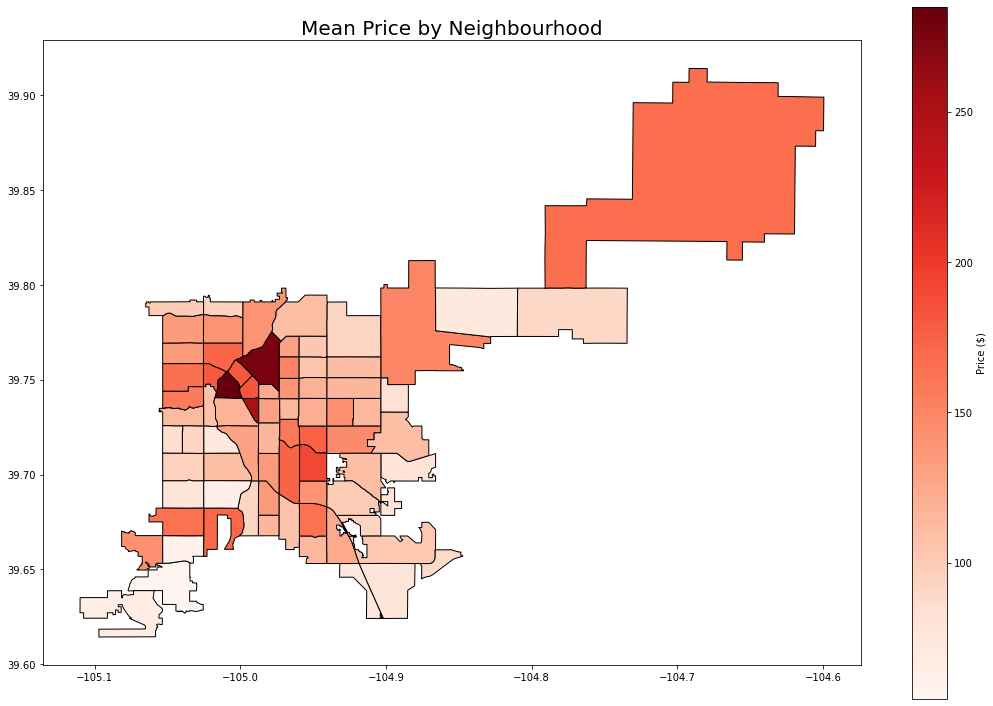

In [36]:
geo_df.plot(column='price', 
            figsize=(15, 10),
            edgecolor='black',
            cmap='Reds',
            legend=True,
           legend_kwds={'label': "Price ($)"})
plt.title('Mean Price by Neighbourhood',fontsize=20)
plt.tight_layout()

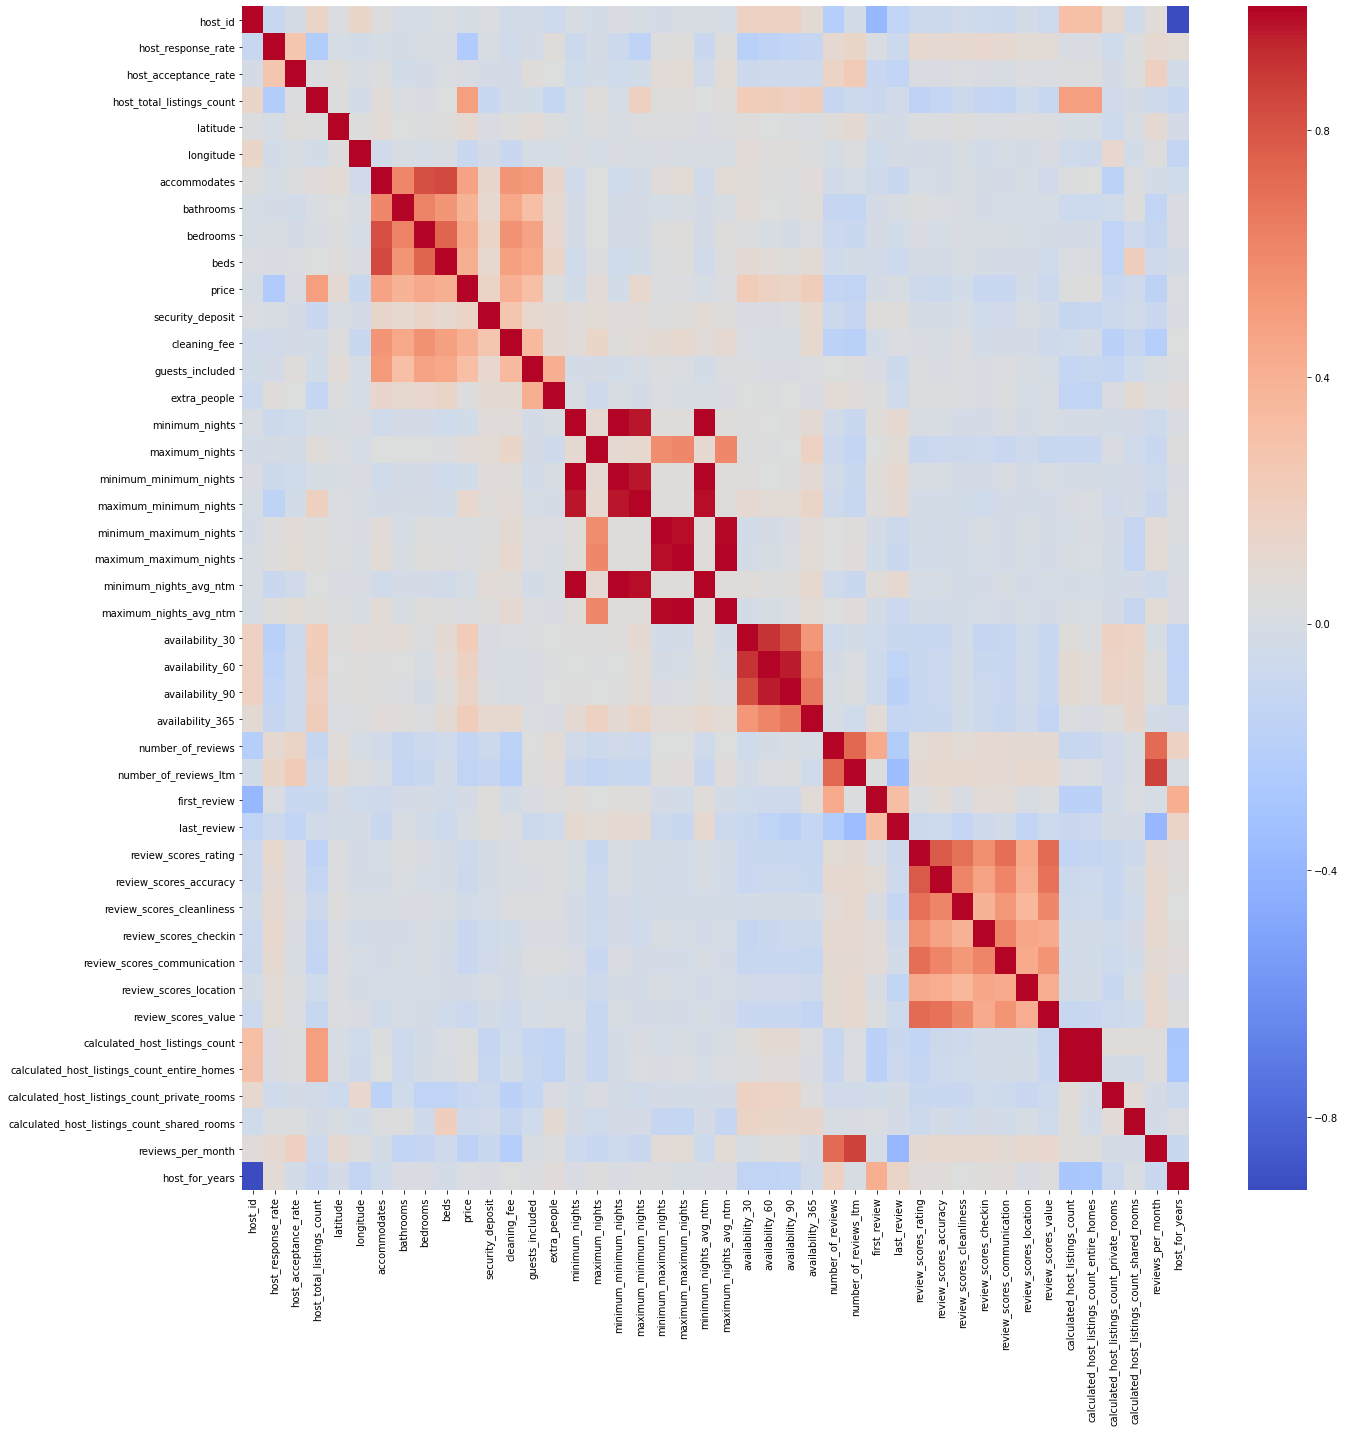

In [37]:
# num = [x for x in df.columns if df[x].dtype == float or df[x].dtype == int]
# df_num = df[num]
fig, ax = plt.subplots(figsize=(20,20))  
sns.heatmap(df.corr(), cmap = 'coolwarm')
plt.tight_layout()
plt.show()


In [38]:
cor= df.corr().abs() 
upper =cor.where(np.triu(np.ones(cor.shape), k=1).astype(np.bool))
high_corr = [column for column in upper.columns if any(upper[column] > 0.90)]

In [39]:
high_corr

['minimum_minimum_nights',
 'maximum_minimum_nights',
 'maximum_maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'availability_60',
 'availability_90',
 'calculated_host_listings_count_entire_homes',
 'host_for_years']

In [40]:
df.drop(columns = high_corr, inplace = True)

In [41]:
for i in df.columns:
    print(i)

host_id
host_response_time
host_response_rate
host_acceptance_rate
host_is_superhost
host_neighbourhood
host_total_listings_count
host_has_profile_pic
host_identity_verified
neighbourhood_cleansed
city
zipcode
latitude
longitude
is_location_exact
property_type
room_type
accommodates
bathrooms
bedrooms
beds
bed_type
price
security_deposit
cleaning_fee
guests_included
extra_people
minimum_nights
maximum_nights
minimum_maximum_nights
availability_30
availability_365
number_of_reviews
number_of_reviews_ltm
first_review
last_review
review_scores_rating
review_scores_accuracy
review_scores_cleanliness
review_scores_checkin
review_scores_communication
review_scores_location
review_scores_value
requires_license
instant_bookable
cancellation_policy
require_guest_profile_picture
require_guest_phone_verification
calculated_host_listings_count
calculated_host_listings_count_private_rooms
calculated_host_listings_count_shared_rooms
reviews_per_month


In [42]:
df_catigorical = df.select_dtypes(include = 'object').copy()

df_stats = pd.DataFrame(columns = ['column', 'values'])
tmp = pd.DataFrame()

for c  in df_catigorical.columns:
    tmp['column'] = [c]
    tmp['values'] = [df_catigorical[c].unique()]
    tmp['values_count_incna'] = len(list(df_catigorical[c].unique()))
    tmp['values_count_nona'] = int(df_catigorical[c].nunique())
    df_stats = df_stats.append(tmp)

df_stats.sort_values(by = 'values_count_incna', inplace = True, ascending = False)
df_stats.set_index('column', inplace = True)
df_stats

,values,values_count_incna,values_count_nona
column,,,
host_neighbourhood,"[virginia village, highland, five points, nort...",118.0,118.0
neighbourhood_cleansed,"[virginia village, highland, five points, nort...",78.0,78.0
zipcode,"[80246, 80211, 80205, 80207, 80223, 80220, 802...",41.0,41.0
property_type,"[guesthouse, loft, house, apartment, guest sui...",22.0,22.0
city,"[denver, englewood, lakewood, wheat ridge, aur...",9.0,9.0
cancellation_policy,"[strict_14_with_grace_period, flexible, modera...",5.0,5.0
bed_type,"[real bed, futon, airbed, pull-out sofa, couch]",5.0,5.0
host_response_time,"[within an hour, within a few hours, within a ...",4.0,4.0
room_type,"[entire home/apt, private room, shared room, h...",4.0,4.0


In [43]:
df_catigorical['price'] = df.loc[df_catigorical.index, 'price'].copy()

In [44]:
df_catigorical_big = df_catigorical[['host_neighbourhood','neighbourhood_cleansed','zipcode','property_type']]
df_catigorical.drop(columns = ['host_neighbourhood','neighbourhood_cleansed','zipcode','property_type'],inplace = True)

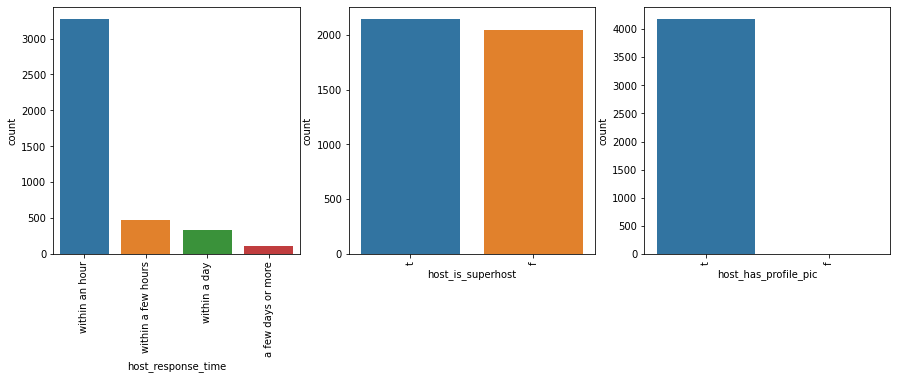

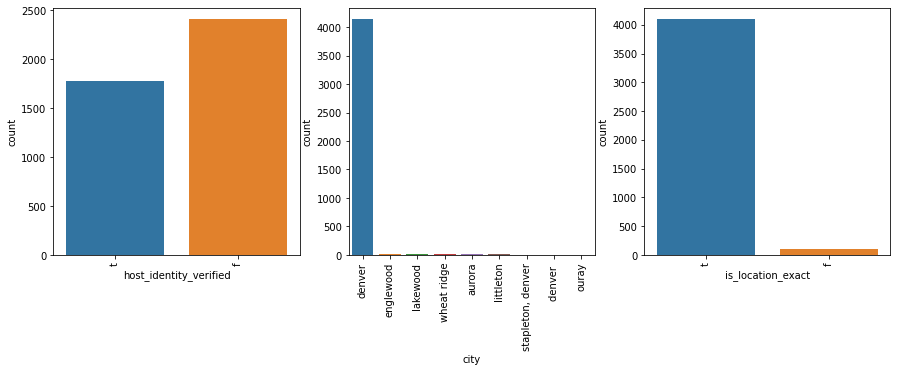

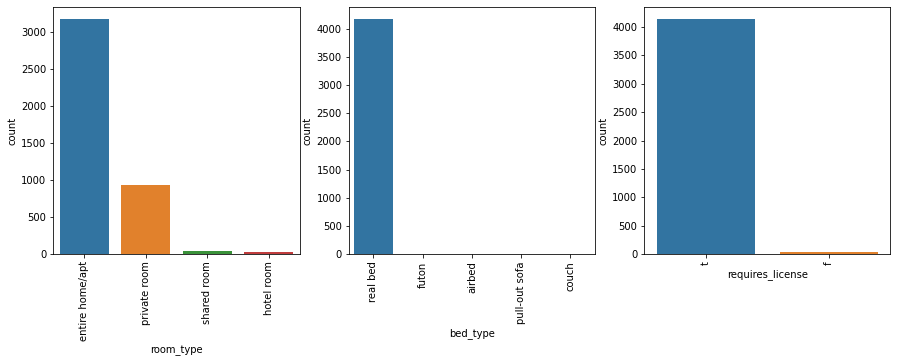

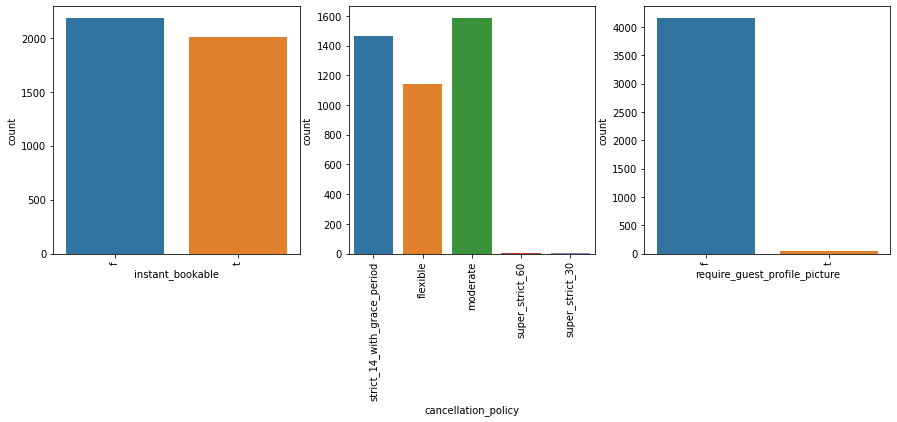

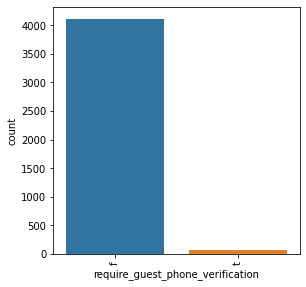

In [45]:
ix = 1
fig = plt.figure(figsize = (15,10))
for c in list(df_catigorical.columns):
    if ix <= 3:
        if c != 'price':
            ax1 = fig.add_subplot(2,3,ix)
            chart = sns.countplot(data = df_catigorical, x=c, ax = ax1)
            chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
    ix = ix +1
    if ix == 4: 
        fig = plt.figure(figsize = (15,10))
        ix =1

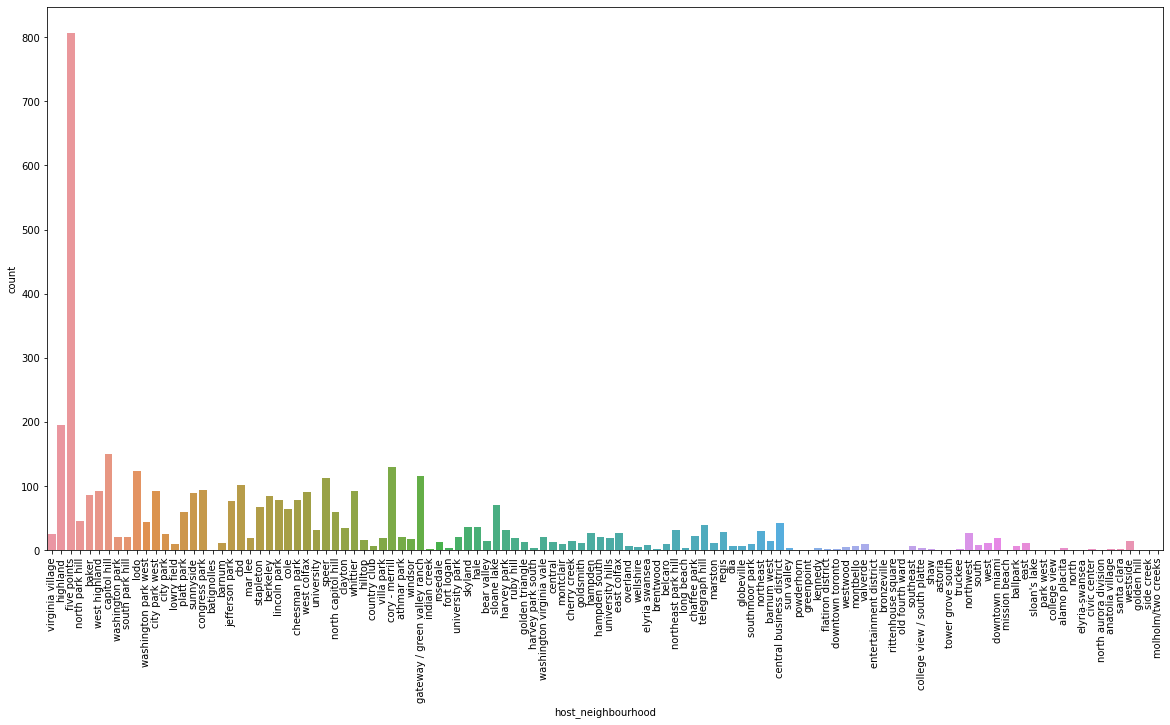

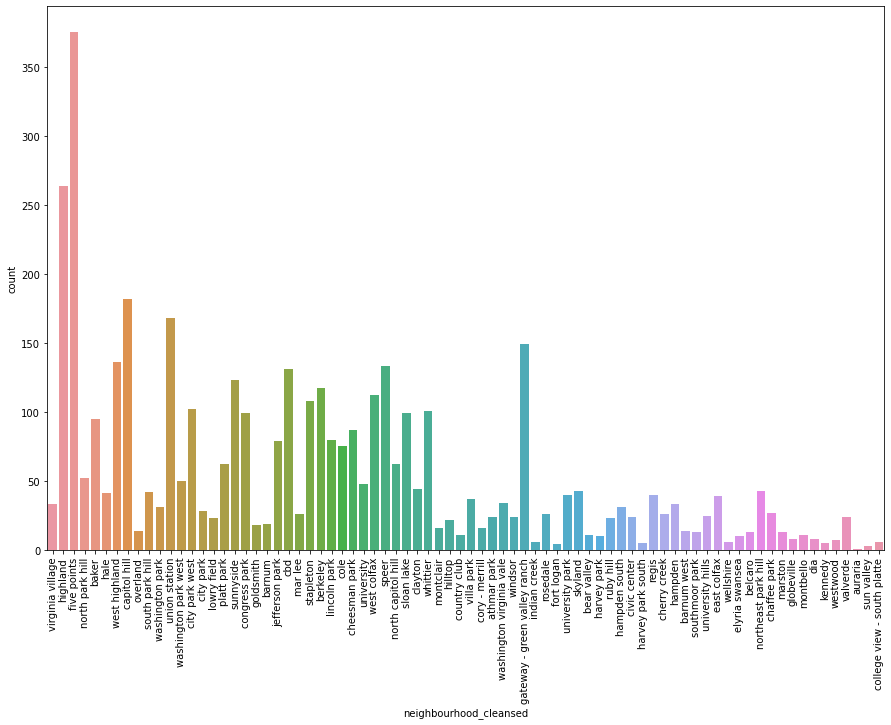

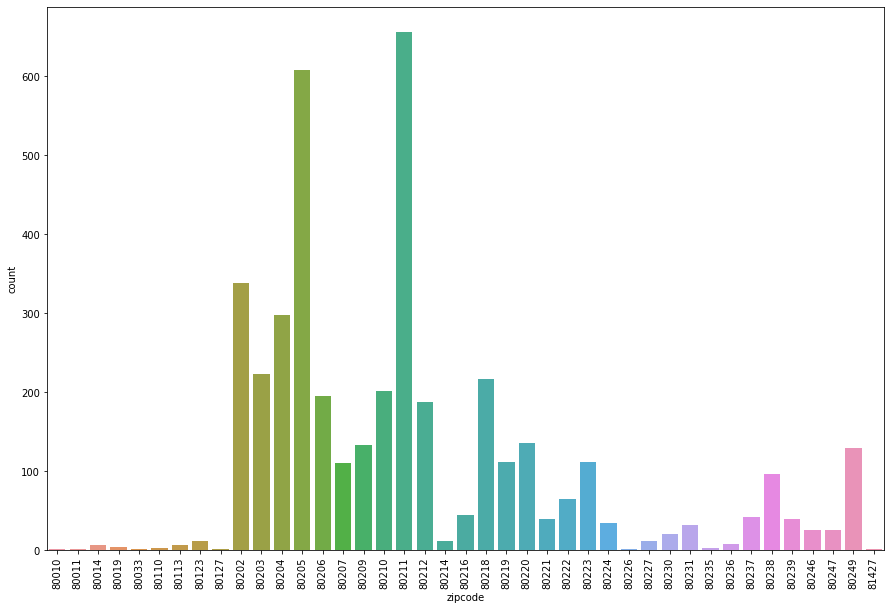

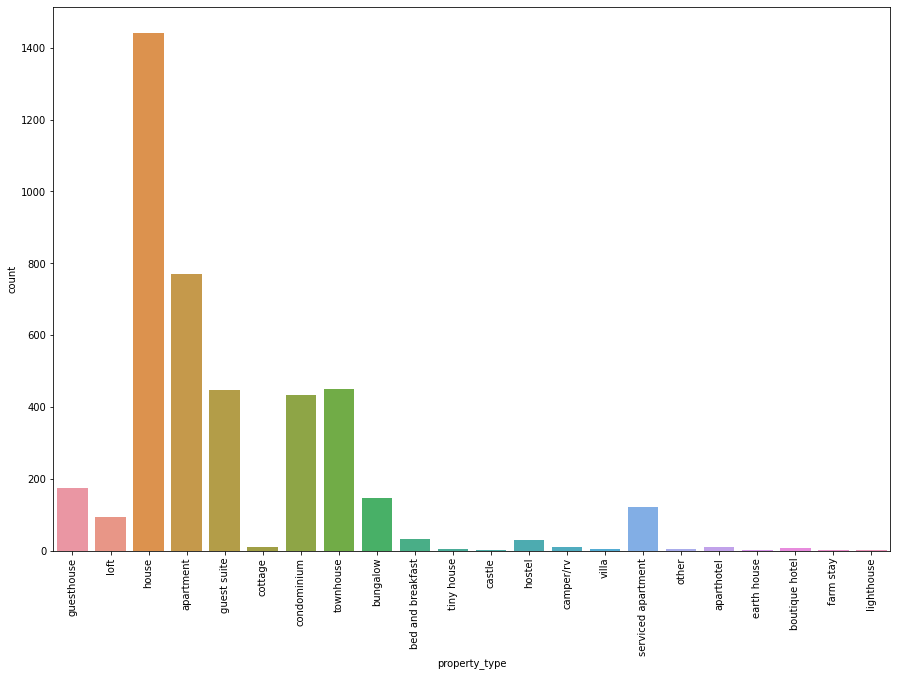

<Figure size 1080x720 with 0 Axes>

In [46]:
fig = plt.figure(figsize = (20,10))
for c in list(df_catigorical_big.columns):
    if c != 'price':
        ax1 = fig.add_subplot(1,1,1)
        chart = sns.countplot(data = df_catigorical_big, x=c, ax = ax1)
        chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
    fig = plt.figure(figsize = (15,10))


In [47]:
print(df.groupby('host_has_profile_pic')['host_id'].count())
print(df.groupby('bed_type')['host_id'].count())

host_has_profile_pic
f       5
t    4185
Name: host_id, dtype: int64
bed_type
airbed              3
couch               2
futon               8
pull-out sofa       7
real bed         4170
Name: host_id, dtype: int64


In [48]:
cat_update = ['city','bed_type','property_type','host_neighbourhood']
for j in cat_update:
    frequencies = df[j].value_counts(normalize=True, ascending=True)
    threshold = frequencies[(frequencies.cumsum() > 0.1).idxmax()]
    df[j] = df[j].mask(df[j].map(df[j].value_counts(normalize=True)) < threshold, 'Other')


In [49]:
df_catigorical = df.select_dtypes(include = 'object').copy()

df_stats = pd.DataFrame(columns = ['column', 'values', 'values_count_incna', 'values_count_nona'])
tmp = pd.DataFrame()

for c  in df_catigorical.columns:
    tmp['column'] = [c]
    tmp['values'] = [df_catigorical[c].unique()]
    tmp['values_count_incna'] = len(list(df_catigorical[c].unique()))
    tmp['values_count_nona'] = int(df_catigorical[c].nunique())
    df_stats = df_stats.append(tmp)

df_stats.sort_values(by = 'values_count_incna', inplace = True, ascending = False)
df_stats.set_index('column', inplace = True)
df_stats

,values,values_count_incna,values_count_nona
column,,,
neighbourhood_cleansed,"[virginia village, highland, five points, nort...",78,78
host_neighbourhood,"[virginia village, highland, five points, nort...",54,54
zipcode,"[80246, 80211, 80205, 80207, 80223, 80220, 802...",41,41
property_type,"[guesthouse, Other, house, apartment, guest su...",8,8
cancellation_policy,"[strict_14_with_grace_period, flexible, modera...",5,5
host_response_time,"[within an hour, within a few hours, within a ...",4,4
room_type,"[entire home/apt, private room, shared room, h...",4,4
bed_type,"[real bed, Other]",2,2
require_guest_profile_picture,"[f, t]",2,2


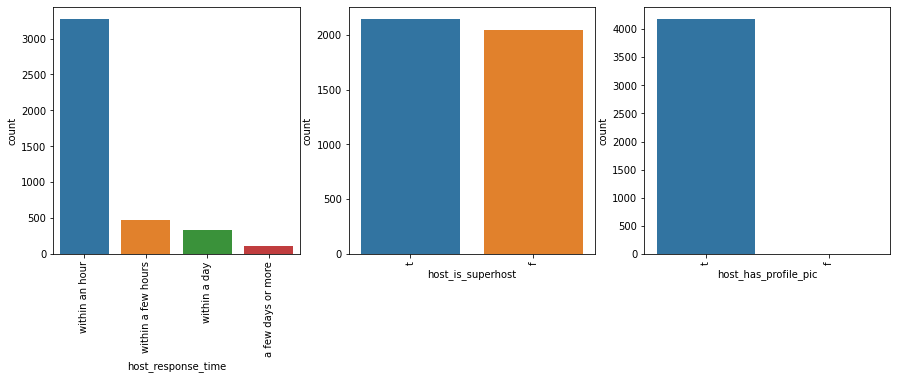

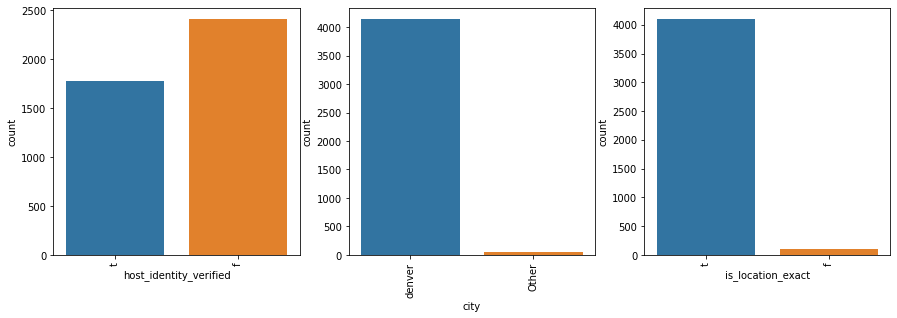

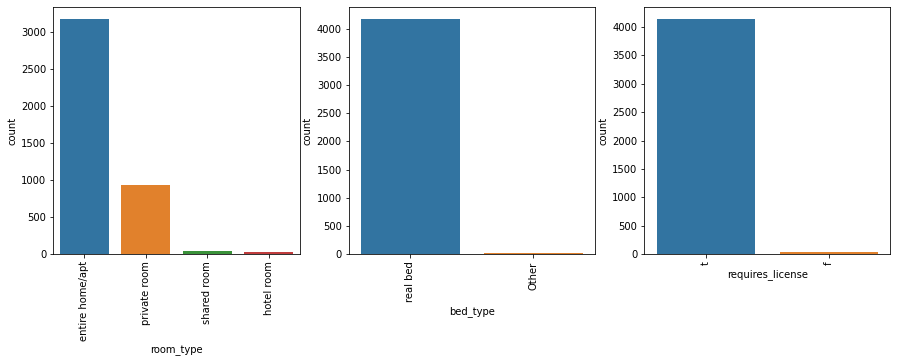

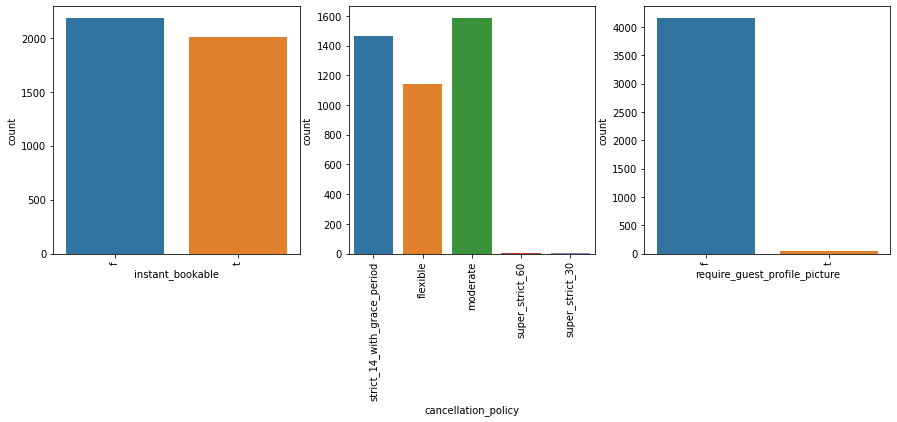

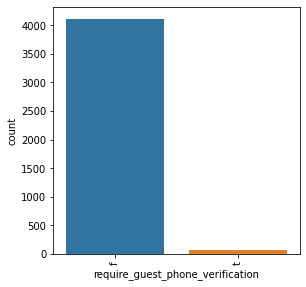

In [50]:
df_catigorical['price'] = df.loc[df_catigorical.index, 'price'].copy()
df_catigorical_big = df_catigorical[['host_neighbourhood','neighbourhood_cleansed','zipcode','property_type']]
df_catigorical.drop(columns = ['host_neighbourhood','neighbourhood_cleansed','zipcode','property_type'],inplace = True)
ix = 1
fig = plt.figure(figsize = (15,10))
for c in list(df_catigorical.columns):
    if ix <= 3:
        if c != 'price':
            ax1 = fig.add_subplot(2,3,ix)
            chart = sns.countplot(data = df_catigorical, x=c, ax = ax1)
            chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
    ix = ix +1
    if ix == 4: 
        fig = plt.figure(figsize = (15,10))
        ix =1


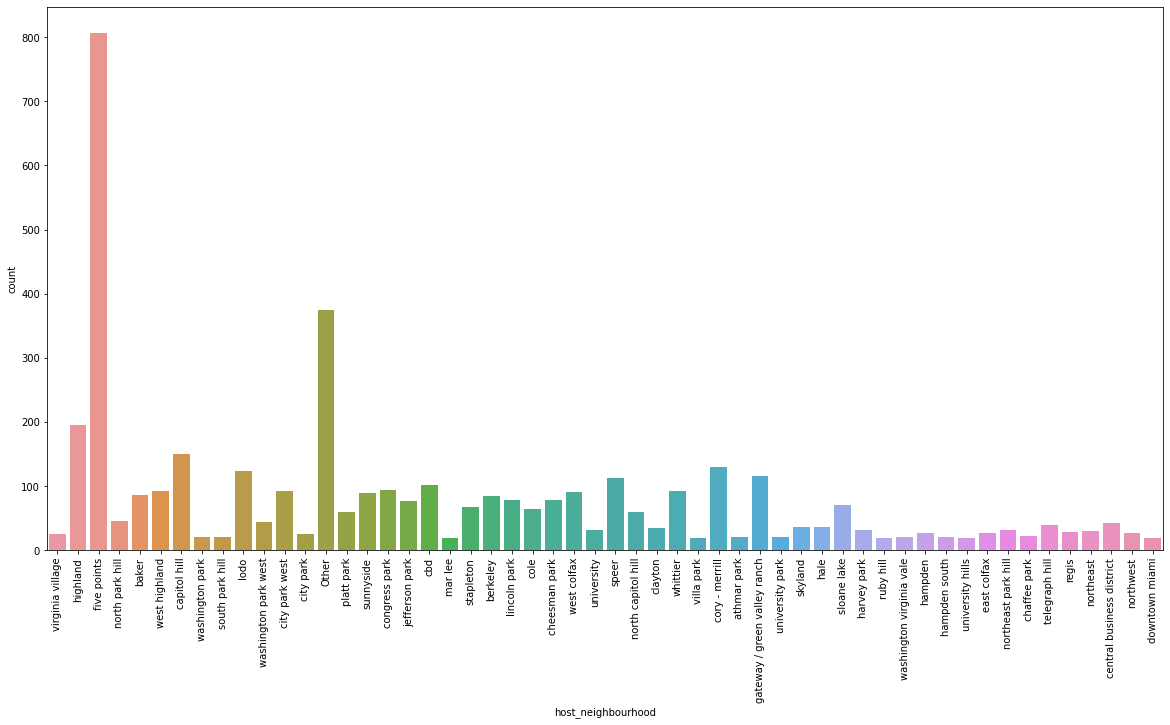

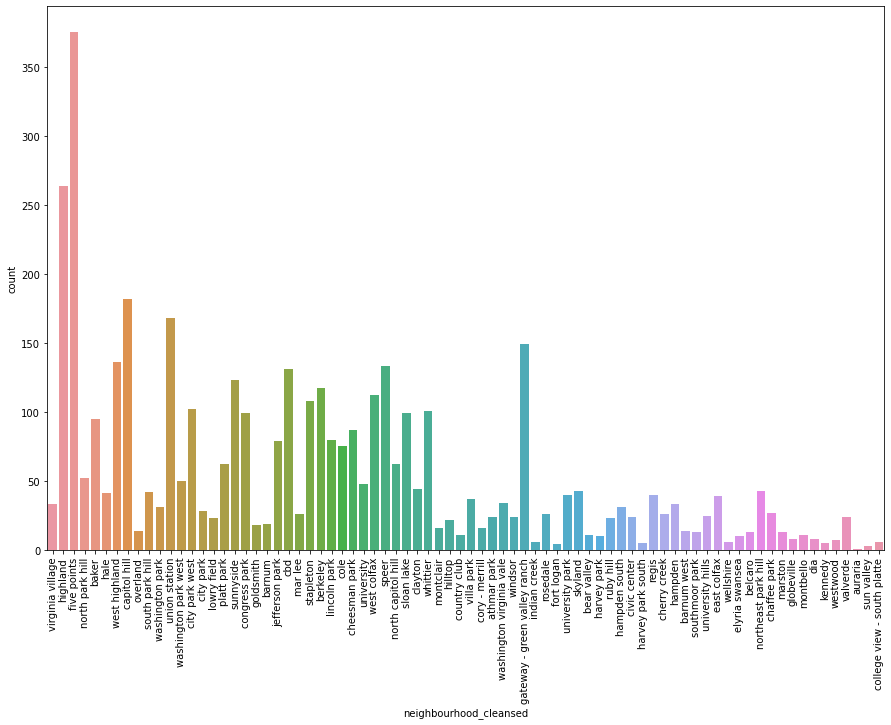

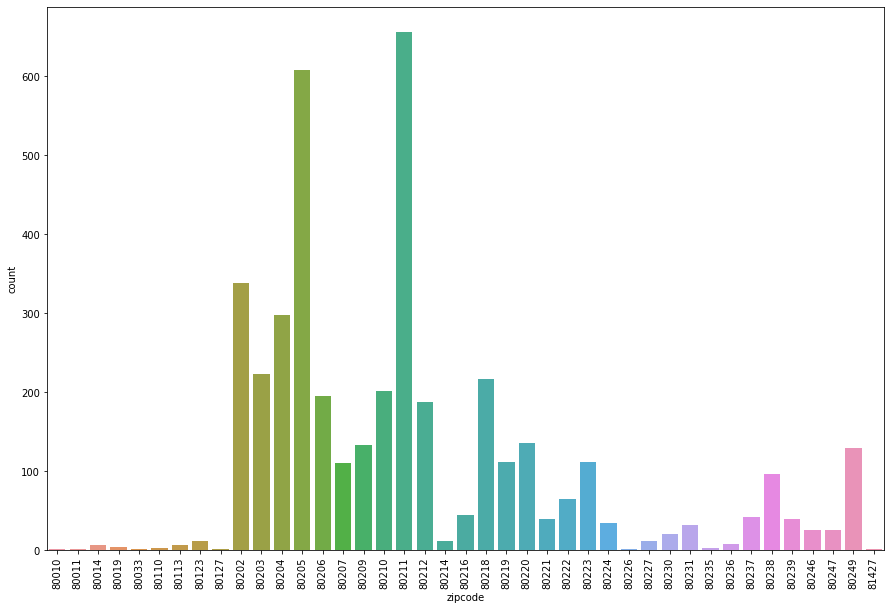

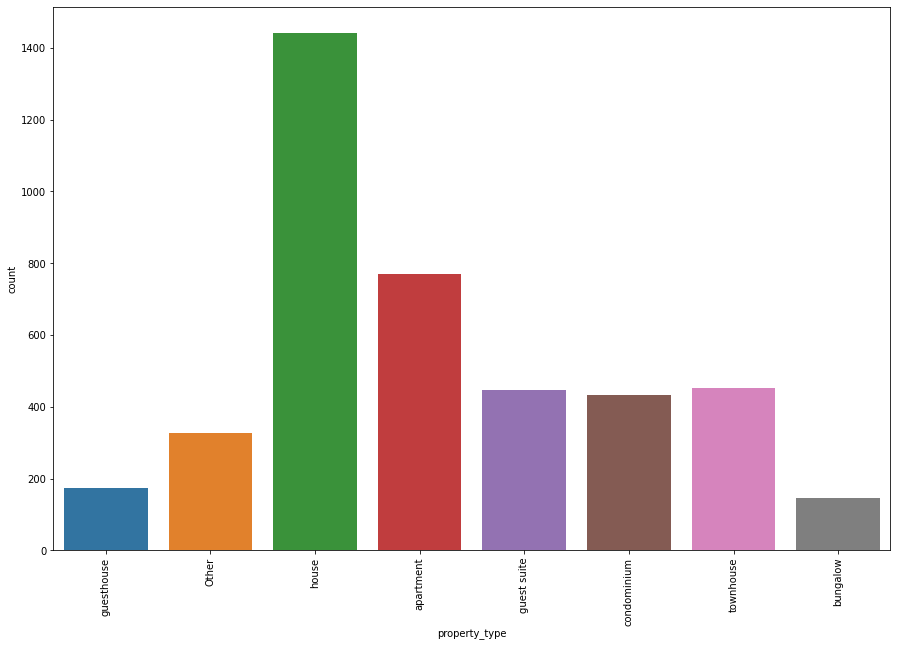

<Figure size 1080x720 with 0 Axes>

In [51]:
fig = plt.figure(figsize = (20,10))
for c in list(df_catigorical_big.columns):
    if c != 'price':
        ax1 = fig.add_subplot(1,1,1)
        chart = sns.countplot(data = df_catigorical_big, x=c, ax = ax1)
        chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
    fig = plt.figure(figsize = (15,10))


In [53]:
df_int_float = df.select_dtypes(include = ['int','float']).copy()

In [54]:
df_int_float.describe()

,host_id,host_response_rate,host_acceptance_rate,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,4.190000e+03,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,...,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000
mean,1.003433e+08,0.950094,0.921718,52.159666,39.740856,-104.974167,4.155847,1.448915,1.645812,2.113996,...,9.831317,9.746454,9.891425,9.870831,9.854763,9.685338,7.685919,0.611456,0.109308,2.157293
std,9.996277e+07,0.142984,0.149871,213.715698,0.031957,0.058902,2.692094,0.856228,1.088552,1.597090,...,0.536817,0.610069,0.437333,0.488308,0.409421,0.610699,20.647982,1.515532,1.067090,1.957194
min,6.150000e+02,0.000000,0.000000,0.000000,39.624320,-105.109860,1.000000,0.000000,0.000000,0.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.010000
25%,1.898859e+07,0.949928,0.921816,1.000000,39.727848,-105.010770,2.000000,1.000000,1.000000,1.000000,...,9.831081,9.746340,10.000000,10.000000,9.854970,9.684596,1.000000,0.000000,0.000000,0.612500
50%,5.648113e+07,1.000000,0.970000,1.000000,39.748130,-104.982725,4.000000,1.000000,1.000000,2.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,0.000000,0.000000,1.990000
75%,1.637809e+08,1.000000,1.000000,3.000000,39.761530,-104.958140,6.000000,2.000000,2.000000,3.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,3.000000,1.000000,0.000000,2.840000
max,3.520454e+08,1.000000,1.000000,2014.000000,39.812460,-104.735070,24.000000,17.000000,13.000000,16.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,118.000000,15.000000,13.000000,16.350000


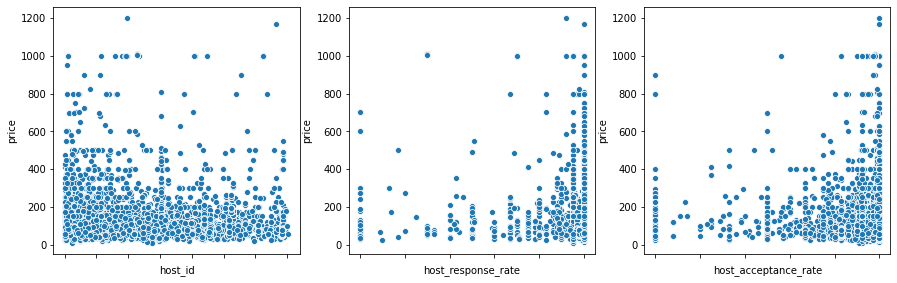

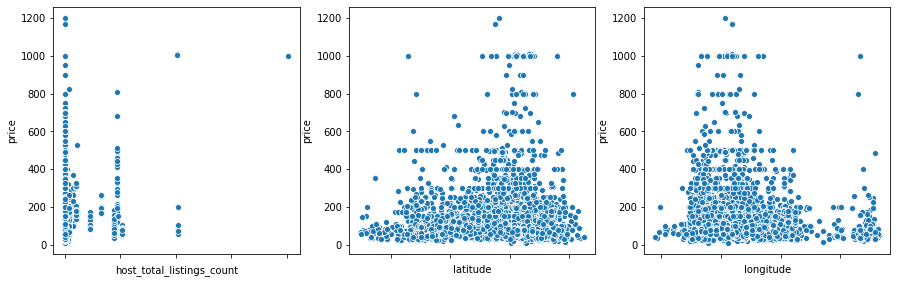

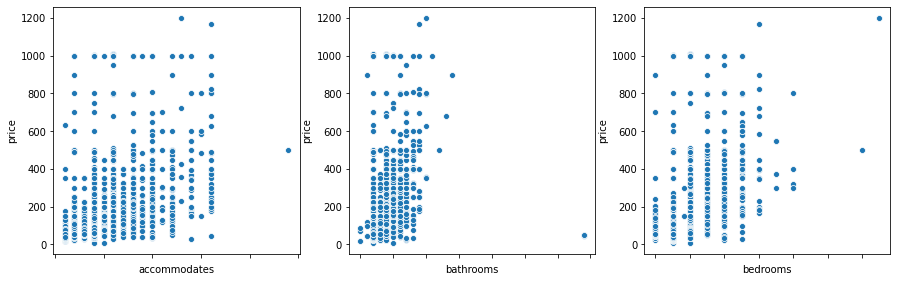

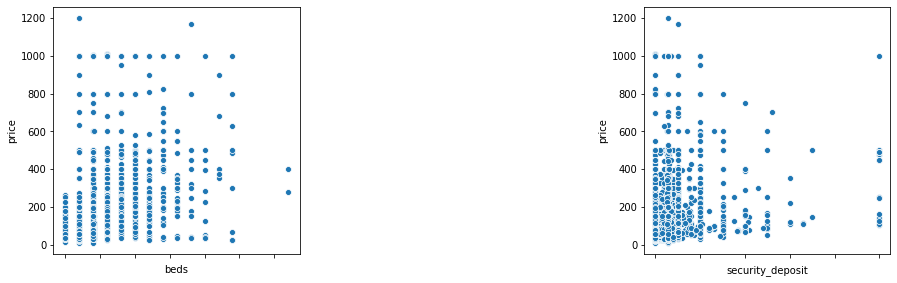

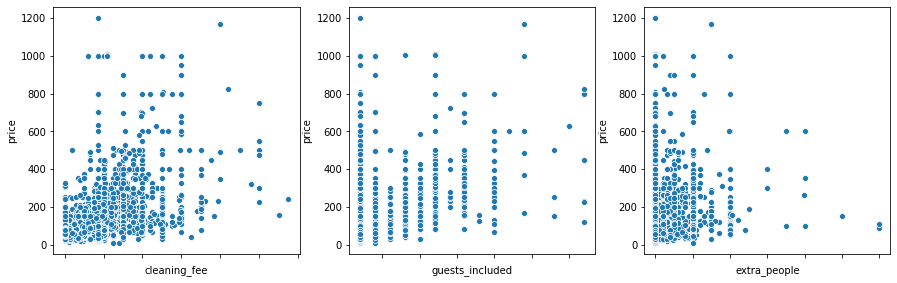

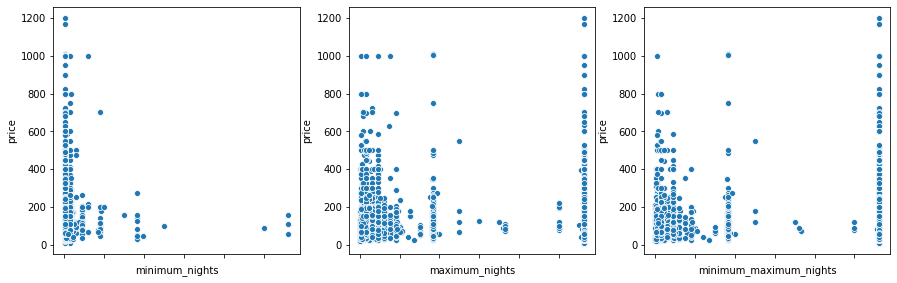

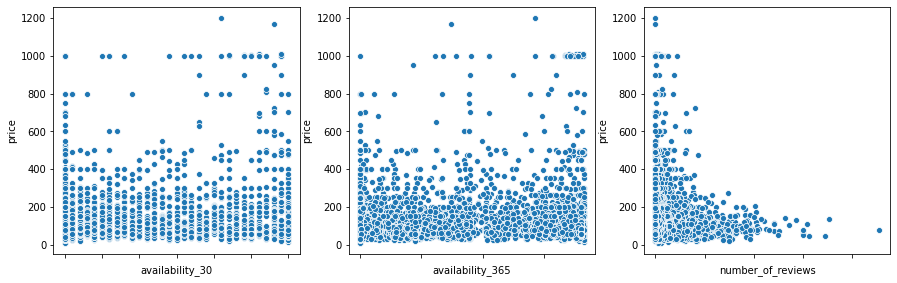

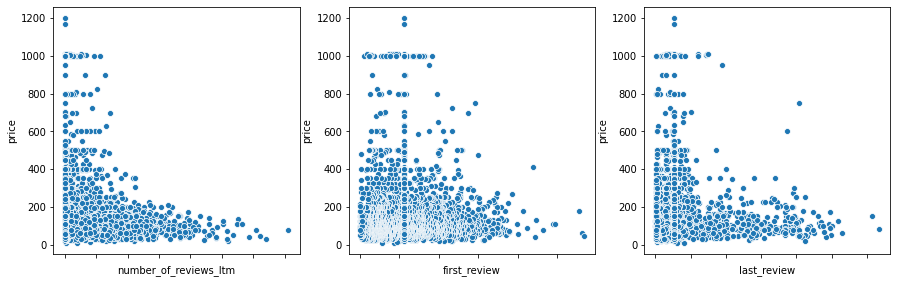

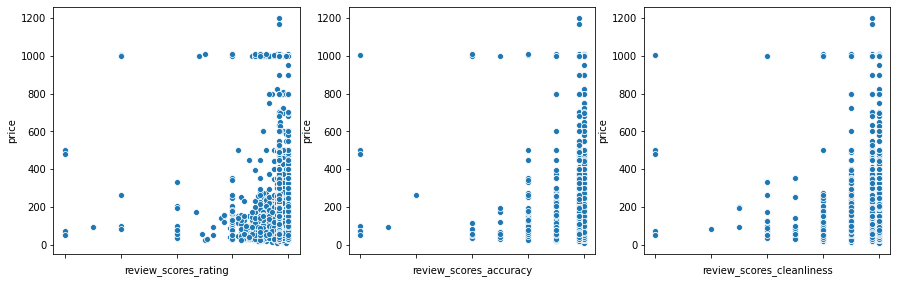

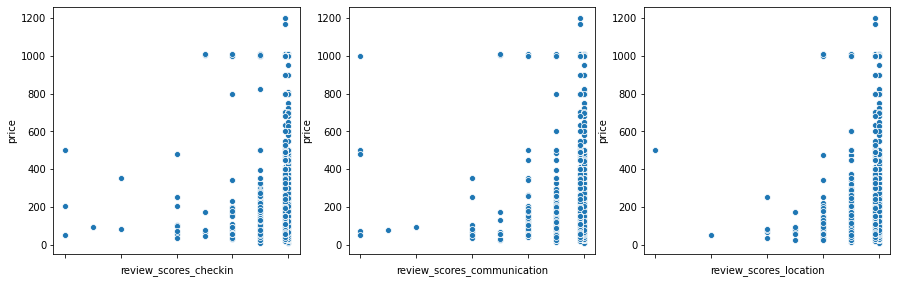

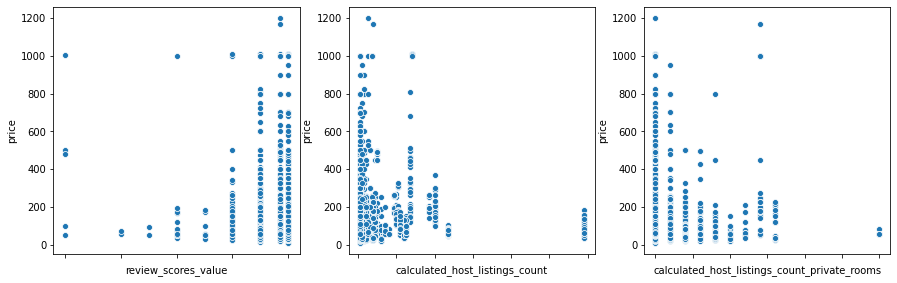

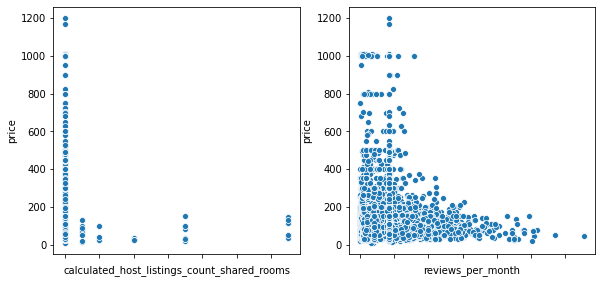

In [59]:
fig = plt.figure(figsize = (15,10))
ix = 1
for c in list(df_int_float.columns):
    if ix <= 3:
        if c != 'price':
            ax1 = fig.add_subplot(2,3,ix)
            chart = sns.scatterplot(x=c, y="price", data=df_int_float, ax=ax1)
            chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
    ix = ix +1
    if ix == 4: 
        fig = plt.figure(figsize = (15,10))
        ix =1

## 3. One-Hot Encoding

In [60]:
x = df.drop('price', axis=1).copy()

In [61]:
y = y = df['price'].copy()

In [64]:
x_encode = pd.get_dummies(x,x.select_dtypes(include = 'object').columns)

In [67]:
x_encode.head()

,host_id,host_response_rate,host_acceptance_rate,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,...,instant_bookable_t,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,require_guest_profile_picture_f,require_guest_profile_picture_t,require_guest_phone_verification_f,require_guest_phone_verification_t
0,615,1.000000,0.980000,2,39.69585,-104.92582,2,1.0,0.0,0.0,...,0,0,0,1,0,0,1,0,1,0
1,666,1.000000,0.990000,3,39.76703,-105.00256,3,1.0,2.0,2.0,...,0,0,0,1,0,0,0,1,0,1
2,783,0.949928,0.921816,1,39.76551,-104.97902,3,1.5,1.0,1.0,...,0,0,0,1,0,0,1,0,1,0
3,933,1.000000,0.930000,2,39.75361,-104.91237,3,1.0,1.0,1.0,...,0,1,0,0,0,0,1,0,1,0
4,933,1.000000,0.930000,2,39.75438,-104.91156,2,1.0,1.0,1.0,...,0,1,0,0,0,0,1,0,1,0


In [70]:
x_encode.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('uint8')], dtype=object)

In [71]:
y.dtypes

dtype('float64')

In [77]:
#split data set in to train and test
x_train, x_test, y_train, y_test = train_test_split(x_encode, y, test_size = 0.3,random_state=19)
print((x_train.shape , y_train.shape))
print((x_test.shape , y_test.shape))

((2933, 248), (2933,))
((1257, 248), (1257,))


## Model building 

### Random Forst 